In [1]:
import sys
sys.path.append('../../FGTD/scripts')

In [2]:
!pip install -r /scratch/mnk2978/DL/MINIPROJ3/text2face/requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [3]:
import wandb
wandb.init(project="text-to-face2", name="n-dfgan2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrunal (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Importing dependencies


In [4]:
import os
import random
import functools

import pandas as pd
import numpy as np
from numpy import sqrt, prod
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataclasses import asdict, dataclass

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
!pip install torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import interpolate
from torch.nn.modules.utils import _pair
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [5]:
from dataset import get_weighted_dataloader
from extract_zip import extract_zip
from sentence_encoder import SentenceEncoder

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [6]:
# File Constants
ZIP_PATH = "/scratch/mnk2978/DL/MINIPROJ3/dataset"
OUTPUT_DIR = "/scratch/mnk2978/DL/MINIPROJ3/dataset/img_align_celeba/img_align_celeba"

## Initialize constants

In [7]:
@dataclass
class Config:
    epochs: int = 15
    batch_size: int = 32
    subset_size: int = 20_000
    dataset_len = 202599

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    conditional: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    uncond_loss: int = 1.0
    colour_loss: int = 0.0
    kl_loss: int = 2.0

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [9]:
sentence_encoder = SentenceEncoder(cfg.device)

Some weights of the model checkpoint at /home/mnk2978/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Helper functions

In [10]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [11]:
class ImageTextDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [12]:
dataset = ImageTextDataset(
    root_dir=OUTPUT_DIR, 
    csv_file='/scratch/mnk2978/DL/MINIPROJ3/text2face/dataset/text_5_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
)

## Data Loading

In [13]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/scratch/mnk2978/DL/MINIPROJ3/text2face/dataset/list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Smiling', 'Wavy_Hair', 'Chubby', 'Rosy_Cheeks', 'Young', '5_o_Clock_Shadow', 'High_Cheekbones', 'Pointy_Nose', 'Gray_Hair', 'Wearing_Earrings', 'Narrow_Eyes', 'Eyeglasses', 'Mouth_Slightly_Open', 'Wearing_Necktie', 'Goatee', 'Big_Nose', 'Black_Hair', 'Bald', 'Sideburns', 'Arched_Eyebrows', 'Blond_Hair', 'Heavy_Makeup', 'Attractive', 'Mustache', 'Double_Chin', 'Bushy_Eyebrows', 'Big_Lips', 'Pale_Skin', 'Receding_Hairline', 'Wearing_Necklace', 'Male', 'Brown_Hair', 'Straight_Hair', 'Oval_Face', 'Wearing_Lipstick', 'Wearing_Hat'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


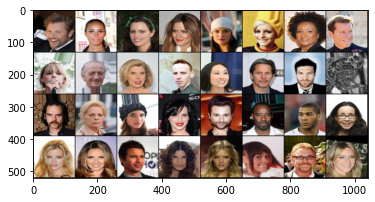

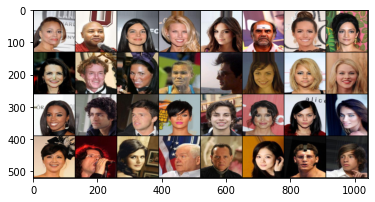

["The gentleman has pretty high cheekbones. He sports a 5 o' clock shadow. He has brown and straight hair. He has a slightly open mouth. The gentleman is smiling, is attractive and young.", 'The female has an oval face. Her hair is straight and receding. She has arched eyebrows, big lips, a big nose, bushy eyebrows and a slightly open mouth. The woman looks attractive, young, has heavy makeup and rosy cheeks. She is wearing earrings and lipstick.', 'The lady has high cheekbones and an oval face. She has wavy hair. She has a slightly open mouth. She seems attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The lady has pretty high cheekbones. The lady is smiling, is attractive, young and has heavy makeup. She is wearing lipstick.', 'She seems attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The female has pretty high cheekbones. She has blond and straight hair. She has big lips and a slightly open mouth. The female looks attractiv

In [14]:
real_images, labels, wrong_images = weighted_dataiter.next()
show_grid(torchvision.utils.make_grid(real_images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [15]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Create Network

In [16]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    
    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)        

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [17]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch 
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [18]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )
    
  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf):
      super(D_GET_LOGITS, self).__init__()
      self.df_dim = ndf

      self.reduced_dim = nn.Linear(768, 256)

      self.joint_conv = nn.Sequential(
          nn.Conv2d(ndf * 16+256, ndf * 2, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(ndf * 2, 1, 2, 1, 0, bias=False),
      )

    def forward(self, out, y):
      y = self.reduced_dim(y)
      y = y.view(-1, 256, 1, 1)
      y = y.repeat(1, 1, 2, 2)
      h_c_code = torch.cat((out, y), 1)
      out = self.joint_conv(h_c_code)
      # print(out.shape)
      return out

In [21]:
class resD(nn.Module):
    def __init__(self, fin, fout, downsample=True):
      super().__init__()
      self.downsample = downsample
      self.learned_shortcut = (fin != fout)
      self.conv_r = nn.Sequential(
          nn.Conv2d(fin, fout, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
          
          nn.Conv2d(fout, fout, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
      )

      self.conv_s = nn.Conv2d(fin,fout, 1, stride=1, padding=0)
      self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, c=None):
      return self.shortcut(x)+self.gamma*self.residual(x)

    def shortcut(self, x):
      if self.learned_shortcut:
          x = self.conv_s(x)
      if self.downsample:
          return F.avg_pool2d(x, 2)
      return x

    def residual(self, x):
      return self.conv_r(x)

In [22]:
class NetD(nn.Module):
    def __init__(self, ndf):
      super(NetD, self).__init__()

      self.conv_img = nn.Conv2d(3, ndf, 3, 1, 1)#128
      self.block0 = resD(ndf * 1, ndf * 2)#64
      self.block1 = resD(ndf * 2, ndf * 4)#32
      self.block2 = resD(ndf * 4, ndf * 8)#16
      self.block3 = resD(ndf * 8, ndf * 16)#8
      self.block4 = resD(ndf * 16, ndf * 16)#4
      self.block5 = resD(ndf * 16, ndf * 16)#4

      self.COND_DNET = D_GET_LOGITS(ndf)

    def forward(self,x):
      out = self.conv_img(x)
      out = self.block0(out)
      out = self.block1(out)
      out = self.block2(out)
      out = self.block3(out)
      out = self.block4(out)
      out = self.block5(out)
      return out

## Training


In [23]:
netG = NetG(64, 100).to(device)
netD = NetD(64).to(device)

netG.cuda().train()
netD.cuda().train()

NetD(
  (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block0): resD(
    (conv_r): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block1): resD(
    (conv_r): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): resD(
    (conv_r): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), s

In [24]:
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004, betas=(0.0, 0.9))  

In [25]:
plt_images, plt_labels, fake_img = weighted_dataiter.next()
fixed_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_embeddings.shape

torch.Size([32, 768])

In [26]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    netG.eval()
    test_images = netG(fixed_noise, fixed_embeddings)
    netG.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)
  
  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

0it [00:00, ?it/s]

Epoch : 1 / 15


/home/mnk2978/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "




Epoch : 1 | Loss_D : 1.2571349143981934 | Loss_G : 0.8382685780525208


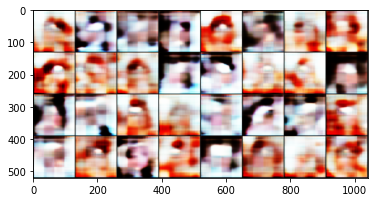

Epoch : 2 / 15


Epoch : 2 | Loss_D : 1.5753496885299683 | Loss_G : 1.0673329830169678


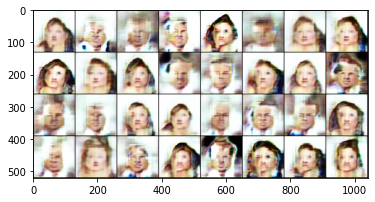

Epoch : 3 / 15


Epoch : 3 | Loss_D : 1.661095380783081 | Loss_G : 0.8280677795410156


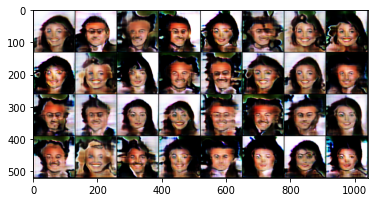

Epoch : 4 / 15


Epoch : 4 | Loss_D : 1.389158844947815 | Loss_G : 0.6829771995544434


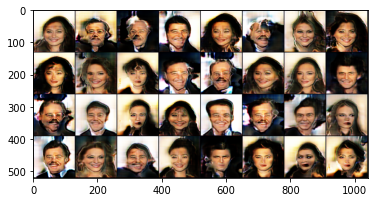

Epoch : 5 / 15


Epoch : 5 | Loss_D : 1.631714105606079 | Loss_G : -0.059353794902563095


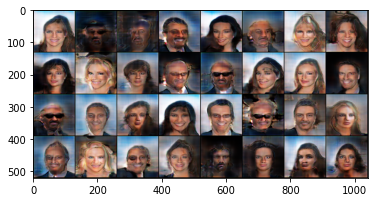

Epoch : 6 / 15


Epoch : 6 | Loss_D : 1.240077018737793 | Loss_G : 0.9300682544708252


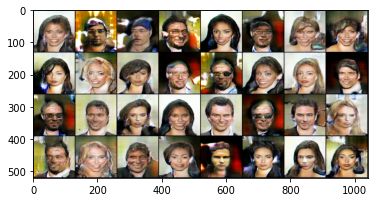

Epoch : 7 / 15


Epoch : 7 | Loss_D : 1.415816068649292 | Loss_G : 1.1027171611785889


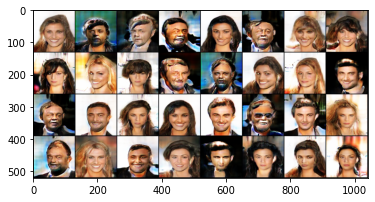

Epoch : 8 / 15


Epoch : 8 | Loss_D : 1.1602396965026855 | Loss_G : 1.2154552936553955


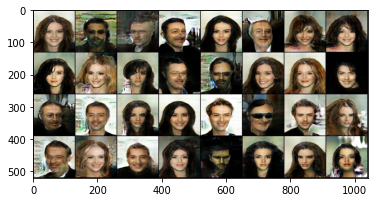

Epoch : 9 / 15


Epoch : 9 | Loss_D : 1.24752676486969 | Loss_G : 1.3359007835388184


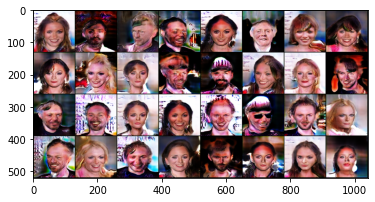

Epoch : 10 / 15


Epoch : 10 | Loss_D : 1.1516072750091553 | Loss_G : 0.4567320942878723


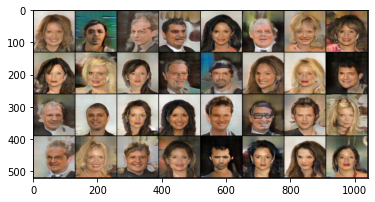

Epoch : 11 / 15


Epoch : 11 | Loss_D : 1.0632823705673218 | Loss_G : 0.4917861223220825


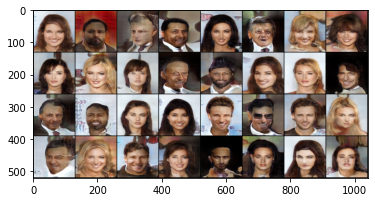

Epoch : 12 / 15


Epoch : 12 | Loss_D : 1.0605357885360718 | Loss_G : 1.750889539718628


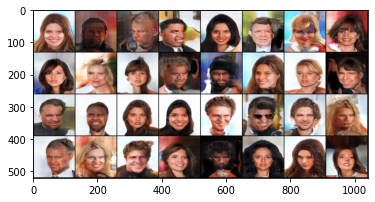

Epoch : 13 / 15


Epoch : 13 | Loss_D : 1.0514774322509766 | Loss_G : 1.505328893661499


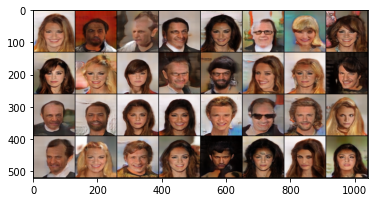

Epoch : 14 / 15


Epoch : 14 | Loss_D : 1.3858497142791748 | Loss_G : 0.9381405115127563


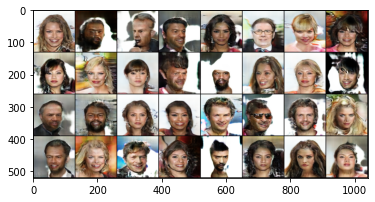

Epoch : 15 / 15


Epoch : 15 | Loss_D : 1.0111676454544067 | Loss_G : 1.9350446462631226


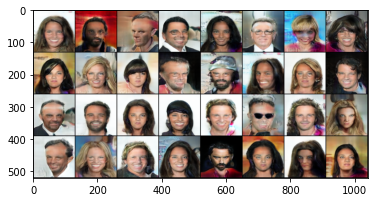

True

In [27]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)

for epoch in range(cfg.epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)    
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach()) 

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()  

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step() 

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)                        
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)
    torch.save(netG.state_dict(), "./checkpoints/checkpoint_generator{}.pth".format(epoch))

pbar.refresh()
  

## Testing

In [28]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The woman has high cheekbones.
She has straight hair which is
brown in colour. She has arched
eyebrows and a slightly open
mouth. The smiling, young attractive woman has heavy makeup. She
is wearing lipstick.
'''])

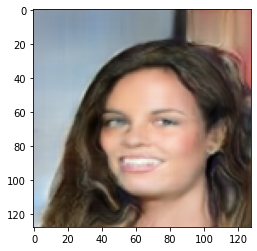

In [29]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [30]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

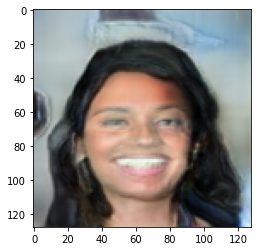

In [31]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))